<a href="https://colab.research.google.com/github/audreyemmely/computer-vision/blob/main/visaocomp_lista4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Resolução Lista 4**
---

ARQUIMEDES VINÍCIUS PEREIRA DE FRANÇA MOURA

AUDREY EMMELY RODRIGUES VASCONCELOS



## Instalação do opencv

In [ ]:
# !pip install opencv-python==4.4.0.44
# !pip install opencv-contrib-python==4.4.0.44

## Importando bibliotecas

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from skimage import io
from google.colab.patches import cv2_imshow

## Questão 1

Leia o seguinte tutorial de calibração de câmera:
https://docs.opencv.org/4.5.2/dc/dbb/tutorial_py_calibration.html

Adapte o código do tutorial e implemente um programa que funcione
o mais próximo possível do tempo real com imagens adquiridas por uma
webcam ou smartphone. Você vai precisar de um tabuleiro de xadrez (pode
imprimir numa folha A4, e colar num papelão ou emplastificar para a geometria ficar fixa). Exiba na tela a rotação e translação da câmera em tempo real, enquanto varia a posição da câmera, mantendo o tabuleiro sempre visível na
imagem. Salve o vídeo e o print da tela.


In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from skimage import io
import glob

def getPhotos():
    cam = cv.VideoCapture(0)
    cv.namedWindow("test")
    img_counter = 0
    while True:
        ret, frame = cam.read()
        if not ret:
            print("failed to grab frame")
            break
        cv.imshow("test", frame)
        k = cv.waitKey(1)
        if k%256 == 27:
            # ESC pressed
            print("Escape hit, closing...")
            break
        elif k%256 == 32:
            # SPACE pressed
            img_name = "opencv_frame_{}.png".format(img_counter)
            cv.imwrite(img_name, frame)
            print("{} written!".format(img_name))
            img_counter += 1
    cam.release()

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
imgs = []
#getPhotos() # pega as fotos da webcam 
#imgs.append(io.imread('https://user-images.githubusercontent.com/25731548/174500736-fe6b1ed7-1b4e-4d6c-817c-0117593d9d40.jpg'))
imgs = glob.glob('*.png')

for img in imgs:
  img = cv.imread(img)
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
                    
  # Find the chess board corners
  ret, corners = cv.findChessboardCorners(gray, (7,6), None)

  # If found, add object points, image points (after refining them)
  if ret == True:
      objpoints.append(objp)

      corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
      imgpoints.append(corners)

      # Draw and display the corners
      cv.drawChessboardCorners(img, (7,6), corners2, ret)
      cv.imshow('img',img)
      cv.waitKey(500)

ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

img = cv.imread('opencv_frame_1.png')
h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv.imwrite('calibresult.png', dst)
cv.imshow('dst',dst)

cv.destroyAllWindows()


# Video

https://drive.google.com/file/d/1dKSTsTmKYNw27fWZy024XdfEFCLBmq17/view?usp=sharing

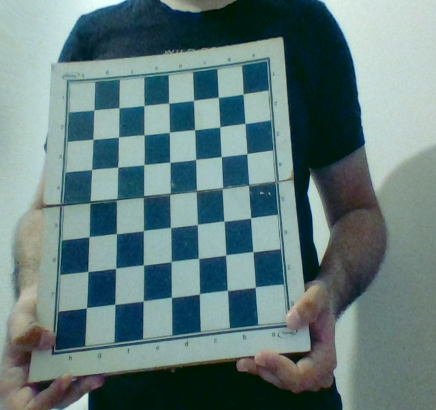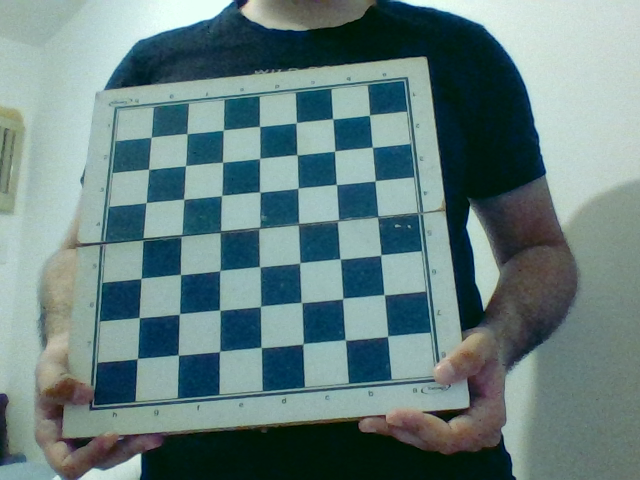

## Questão 2

As fotografias em modo retrato se popularizaram nos últimos anos.
Elas consistem em segmentar foreground e background em uma fotografia, e
borrar o background, simulando o efeito de uma câmera DLSR, como na
imagem abaixo.

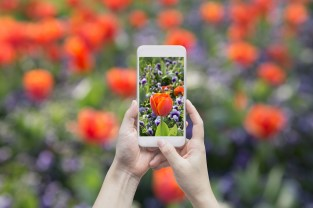

O objetivo dessa questão é simular este efeito, usando mapas de disparidade gerados por duas imagens. Para um tutorial de como gerar mapas de disparidade usando OpenCV, veja https://docs.opencv.org/4.5.2/dd/d53/tutorial_py_depthmap.html. Após a aquisição do mapa de disparidade, você deve usá-lo adequadamente para detectar o foreground, aplicar um filtro gaussiano para borrar apenas o background, e combinar as duas partes para obter um efeito como na figura acima. Experimente seu algoritmo em três pares de imagens adquiridas através de pequenas variações de ponto de vista da câmera.

In [ ]:
img1L = cv.imread('/content/tsukuba_L.png',0)
img1R = cv.imread('/content/tsukuba_R.png',0)

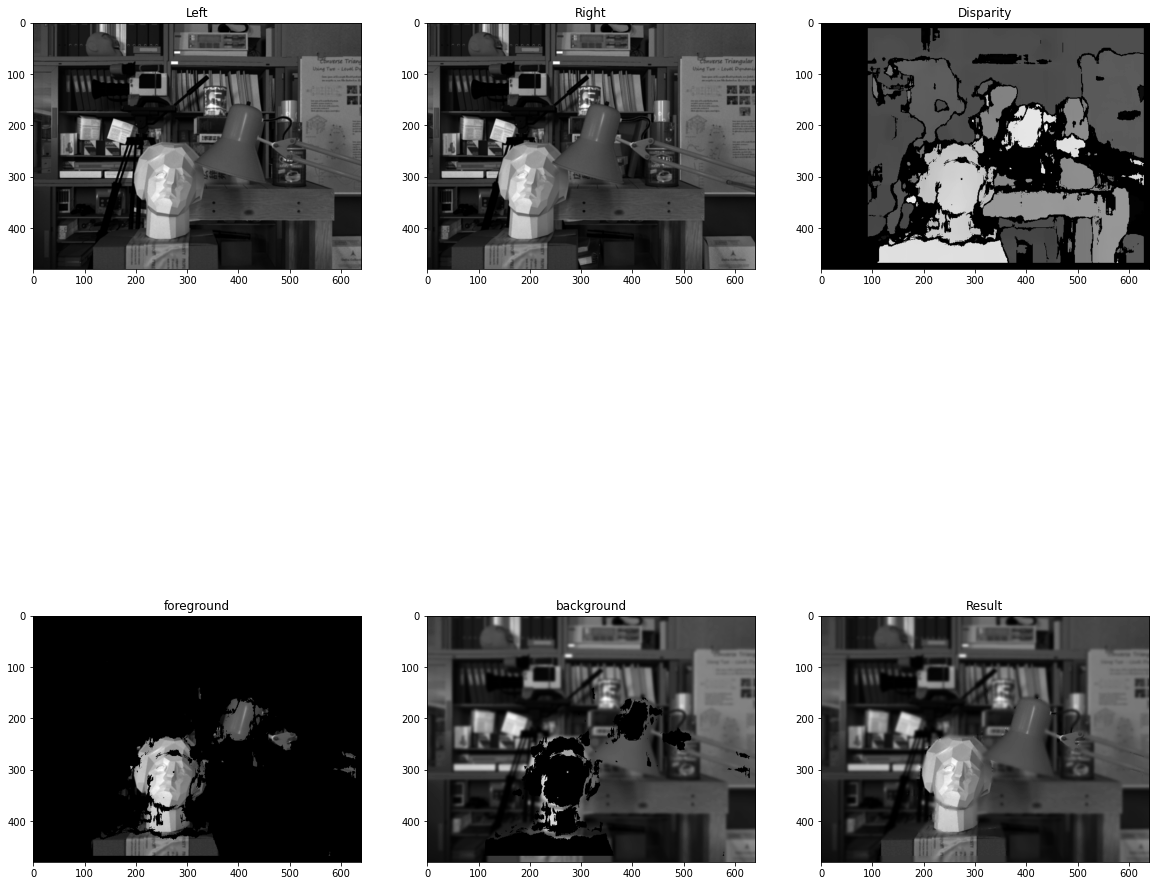

In [ ]:
stereo = cv.StereoBM_create(numDisparities=80, blockSize=25)  
disparity = stereo.compute(img1L,img1R)
disparity = cv.normalize(disparity,  disparity, 0, 255, cv.NORM_MINMAX, dtype=cv.CV_8U)

ret,threshFore = cv.threshold(disparity,175,255,cv.THRESH_BINARY) 
ret,threshBack = cv.threshold(disparity,175,255,cv.THRESH_BINARY_INV)

threshFore = cv.normalize(threshFore,  threshFore, 0.0, 1.0, cv.NORM_MINMAX, dtype=cv.CV_8U)
threshBack = cv.normalize(threshBack,  threshBack, 0.0, 1.0, cv.NORM_MINMAX, dtype=cv.CV_8U)

blurredBG = cv.GaussianBlur(img1L,(13,13),sigmaX=0) 
foreground = cv.bitwise_and(img1L, img1L, mask=threshFore)
background = cv.bitwise_and(blurredBG, blurredBG, mask=threshBack)

full = foreground + background

f, axs = plt.subplots(2,3,figsize=(20,20))
axs[0][0].imshow(cv.cvtColor(img1L,cv.COLOR_BGR2RGB))
axs[0][0].set_title('Left')
axs[0][1].imshow(cv.cvtColor(img1R,cv.COLOR_BGR2RGB))
axs[0][1].set_title('Right')
axs[0][2].imshow(disparity, cmap='gray')
axs[0][2].set_title('Disparity')
axs[1][0].imshow(foreground, cmap='gray')
axs[1][0].set_title('foreground')
axs[1][1].imshow(background, cmap='gray')
axs[1][1].set_title('background')
axs[1][2].imshow(full, cmap='gray')
axs[1][2].set_title('Result')

plt.show()

In [ ]:
img2L = cv.imread('/content/tsukuba2_L.png',0)
img2R = cv.imread('/content/tsukuba2_R.png',0)

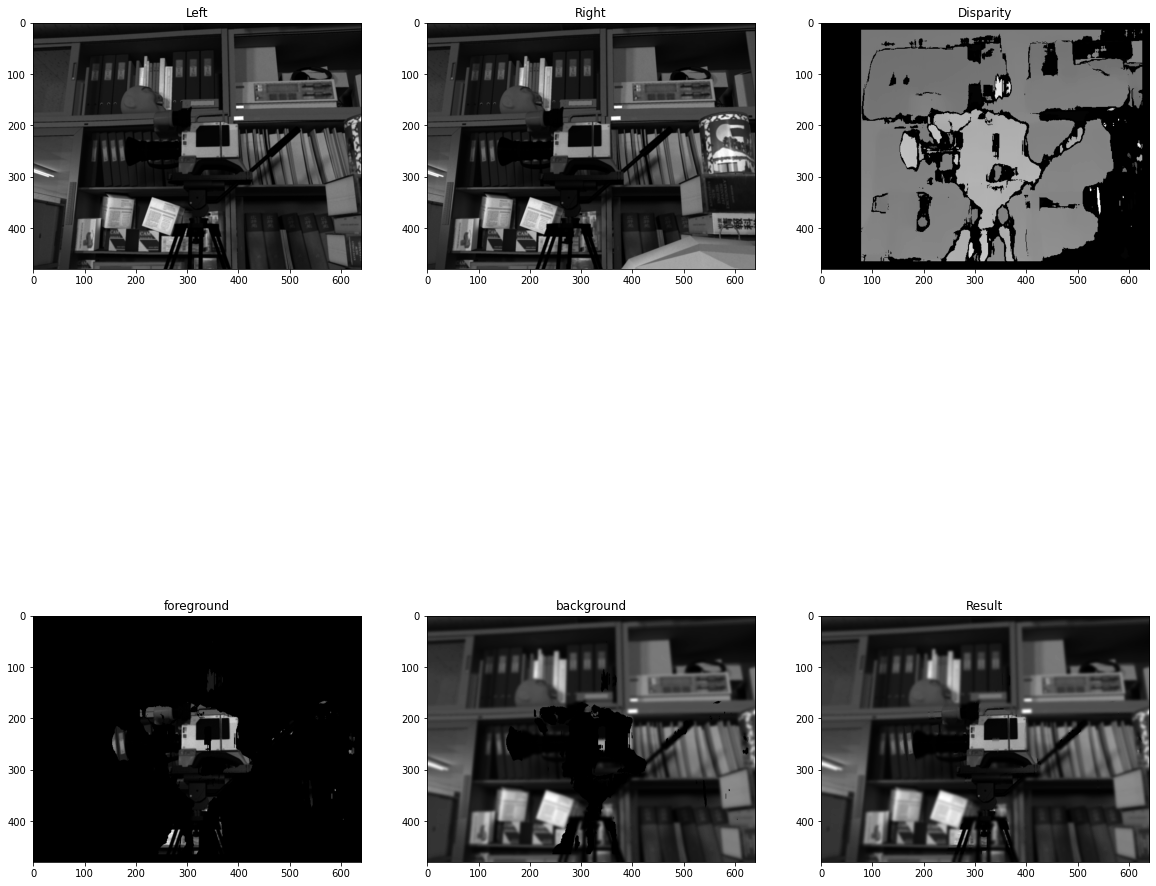

In [ ]:
stereo = cv.StereoBM_create(numDisparities=64, blockSize=31)
disparity = stereo.compute(img2L,img2R)
disparity = cv.normalize(disparity,  disparity, 0, 255, cv.NORM_MINMAX, dtype=cv.CV_8U)

ret,threshFore = cv.threshold(disparity,150,255,cv.THRESH_BINARY) 
ret,threshBack = cv.threshold(disparity,150,255,cv.THRESH_BINARY_INV) 

threshFore = cv.normalize(threshFore,  threshFore, 0.0, 1.0, cv.NORM_MINMAX, dtype=cv.CV_8U)
threshBack = cv.normalize(threshBack,  threshBack, 0.0, 1.0, cv.NORM_MINMAX, dtype=cv.CV_8U)

blurredBG = cv.GaussianBlur(img2L,(13,13),sigmaX=0) 
foreground = cv.bitwise_and(img2L, img2L, mask=threshFore)
background = cv.bitwise_and(blurredBG, blurredBG, mask=threshBack)

full = foreground + background

f, axs = plt.subplots(2,3,figsize=(20,20))
axs[0][0].imshow(cv.cvtColor(img2L,cv.COLOR_BGR2RGB))
axs[0][0].set_title('Left')
axs[0][1].imshow(cv.cvtColor(img2R,cv.COLOR_BGR2RGB))
axs[0][1].set_title('Right')
axs[0][2].imshow(disparity, cmap='gray')
axs[0][2].set_title('Disparity')
axs[1][0].imshow(foreground, cmap='gray')
axs[1][0].set_title('foreground')
axs[1][1].imshow(background, cmap='gray')
axs[1][1].set_title('background')
axs[1][2].imshow(full, cmap='gray')
axs[1][2].set_title('Result')

plt.show()

In [ ]:
img3L = cv.imread('/content/tsukuba3_L.png',0)
img3R = cv.imread('/content/tsukuba3_R.png',0)

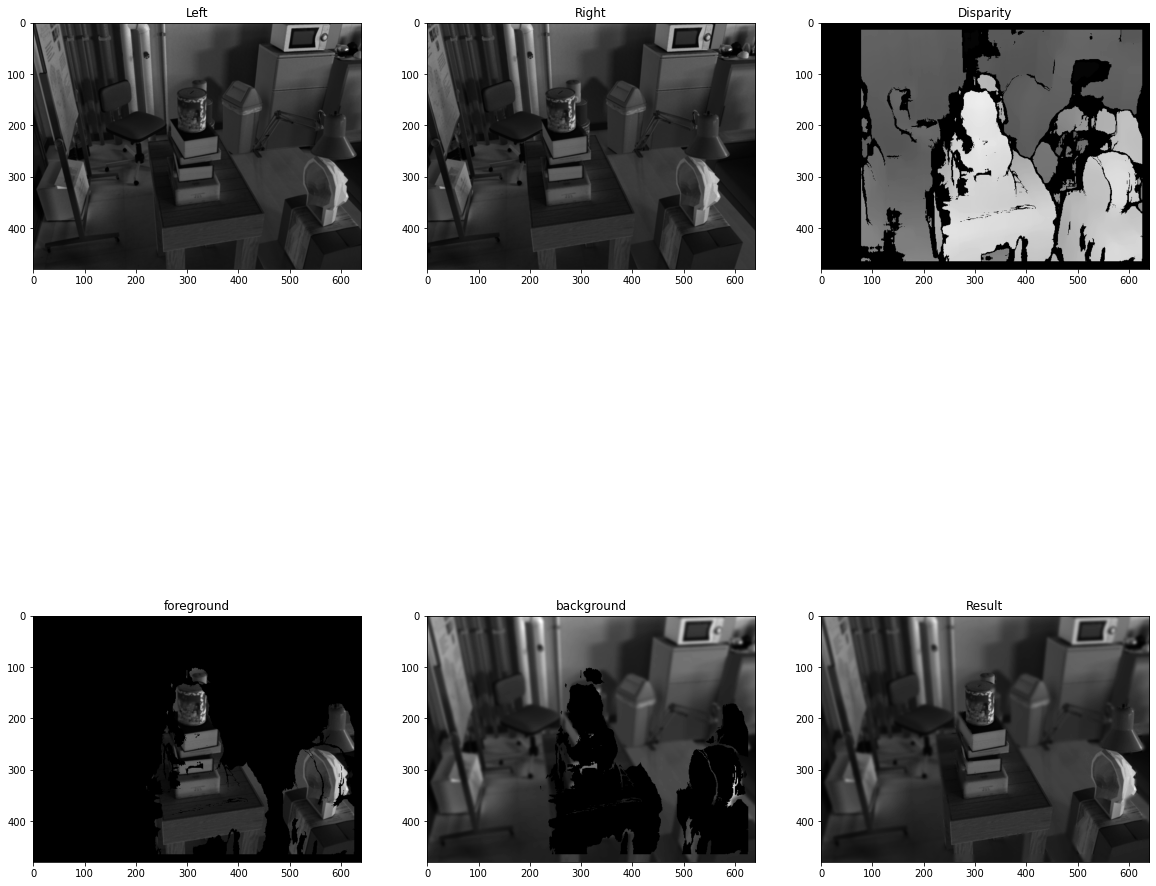

In [ ]:
stereo = cv.StereoBM_create(numDisparities=64, blockSize=31)
disparity = stereo.compute(img3L,img3R)
disparity = cv.normalize(disparity,  disparity, 0, 255, cv.NORM_MINMAX, dtype=cv.CV_8U)

ret,threshFore = cv.threshold(disparity,180,255,cv.THRESH_BINARY)
ret,threshBack = cv.threshold(disparity,180,255,cv.THRESH_BINARY_INV) 

threshFore = cv.normalize(threshFore,  threshFore, 0.0, 1.0, cv.NORM_MINMAX, dtype=cv.CV_8U)
threshBack = cv.normalize(threshBack,  threshBack, 0.0, 1.0, cv.NORM_MINMAX, dtype=cv.CV_8U)

blurredBG = cv.GaussianBlur(img3L,(13,13),sigmaX=0)
foreground = cv.bitwise_and(img3L, img3L, mask=threshFore)
background = cv.bitwise_and(blurredBG, blurredBG, mask=threshBack)

full = foreground + background

f, axs = plt.subplots(2,3,figsize=(20,20))
axs[0][0].imshow(cv.cvtColor(img3L,cv.COLOR_BGR2RGB))
axs[0][0].set_title('Left')
axs[0][1].imshow(cv.cvtColor(img3R,cv.COLOR_BGR2RGB))
axs[0][1].set_title('Right')
axs[0][2].imshow(disparity, cmap='gray')
axs[0][2].set_title('Disparity')
axs[1][0].imshow(foreground, cmap='gray')
axs[1][0].set_title('foreground')
axs[1][1].imshow(background, cmap='gray')
axs[1][1].set_title('background')
axs[1][2].imshow(full, cmap='gray')
axs[1][2].set_title('Result')

plt.show()